In [2]:
import h5py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [2]:
filename = "camera_intrinsics.h5"
main_K, main_distortion = None, None

#Extracts the intrinsic K matrix and distortion vector from the h5 file
with h5py.File(filename, "r") as data:

    main_K = np.array(data["main"]["K"])
    main_distortion = np.array(data["main"]["distortion"])

#Reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

#Uses the intrinsics above to create an undistorted image and save it in a separate file under "proc_main"
images = os.listdir("main")
for file in images:
    img = cv.imread("main/" + file)
    if (img is not None):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv.getOptimalNewCameraMatrix(main_K, main_distortion, (w,h), 1, (w,h))
        undistorted = cv.undistort(img, main_K, main_distortion, None, newcameramtx)

        # crop image
        x, y, w, h = roi
        undistorted = undistorted[y:y+h, x:x+w]

        new_name = "proc_main/proc_" + file
        cv.imwrite(new_name, undistorted)
    

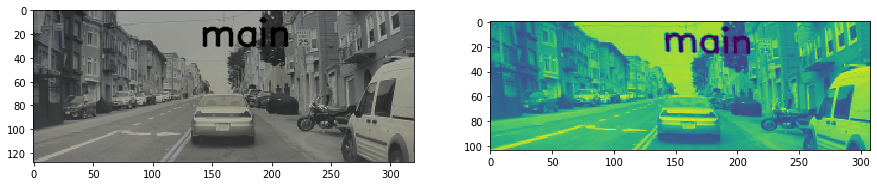

In [156]:
#plots the original and undistorted grayscale image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

dist = cv.imread("main/0050.png")
undist = cv.imread("proc_main/proc_0050.png")
gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)

ax[0].imshow(dist)
ax[1].imshow(gray)

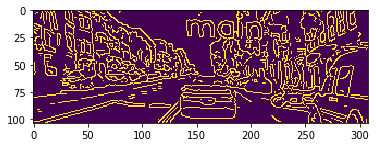

In [157]:
# (Unsuccessful) Canny Filter
blur_gray = cv.GaussianBlur(gray,(3, 3), 0) 
img_can = cv.Canny(blur_gray, 45, 50) #threshold1 = 45, threshold2 = 50
plt.imshow(img_can)

In [158]:
#apply sobel https://medium.com/swlh/computer-vision-advanced-lane-detection-through-thresholding-8a4dea839179

#by trial and error, take a gradient with dx=1, dy=1
sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0)
sobely = cv.Sobel(gray, cv.CV_64F, 0, 1)

#we have to take absolute value, otherwise negative gradients will be taken as 0 when converting to uint8
sobelx_abs = np.absolute(sobelx) 
sobely_abs = np.absolute(sobely)
conv_sobelx = np.uint8(255*sobelx_abs/np.max(sobelx_abs))
conv_sobely = np.uint8(255*sobely_abs/np.max(sobely_abs))

binary = np.zeros_like(conv_sobelx) #create a binary mask of all zeroes
#make binary pixel 1 if the sobel pixel falls within the chosen threshold
binary[((conv_sobelx >= 10) & (conv_sobelx <= 100)) & ((conv_sobely >= 10) & (conv_sobely <= 100))] = 1

#make binary pixel 0 if it is outside of relevant image region
binary[0:60, :] = 0
binary[:, 150:] = 0

Text(0.5, 1, 'Binary for First Order dx, dy')

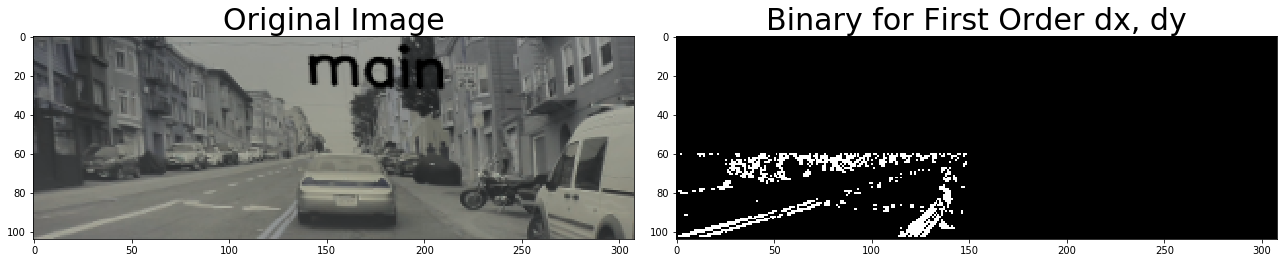

In [159]:
# Plot the result
f, ax = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=30)
ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Binary for First Order dx, dy', fontsize=30)

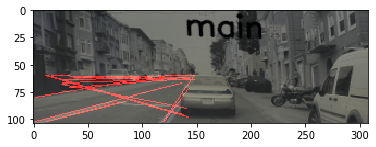

In [160]:

#https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

#create empty image
line_image = np.copy(undist) * 0

#Hough Lines, rho=1 and threshold=1
lines = cv.HoughLinesP(binary, 1, np.pi/180, 25, np.array([]), minLineLength=30, maxLineGap=50)

#Add hough lines to canvas (each line is made up of two endpoints, x1, y1  and x2, y2)
for line in lines:
    for x1, y1, x2, y2 in line:
        pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
        cv.polylines(line_image, [pts], True, (255,0,0))

#Add the canvas w/ lines to the undistorted image and plot
lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)

In [171]:
# #NEW METHOD: color bounds
# lower_bound = np.array([140, 140, 140]) #upper and lower RGB bounds
# upper_bound = np.array([148, 148, 148])
from scipy import optimize

hsv_upper = np.array([91, 10, 255])
hsv_lower = np.array([0, 0, 128])

#find all pixels within this hsv range, in the relevant region of the image
hsv = cv.cvtColor(undist, cv.COLOR_BGR2HSV)
in_bound = cv.inRange(hsv, hsv_lower, hsv_upper)
mask = in_bound & binary

#extract coordinates of each nonzero pixel
pts = np.array([(x, y) for y in range(len(mask[0])) for x in range(len(mask)) if mask[x, y] > 0])
ptsx = [pt[0] for pt in pts]
ptsy = [pt[1] for pt in pts]

#fit the points to a degree-3 polynomial
fit = optimize.curve_fit(ptsx, ptsy, 1)
print(fit)
curve = np.poly1d(fit)
x_range = np.linspace(0, len(mask[0]))
y_range = curve(x_range)

# #plotting pixels within the color bounds [0] and the fit overlaid on the undistorted image [1]
fig, ax = plt.subplots(1, 2, figsize = (20, 15))

ax[0].imshow(mask)
ax[1].plot(x_range, y_range, linewidth=6)
ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 100)

ax[1].imshow(undist)
ax[1].invert_yaxis()

TypeError: [101, 101, 101, 99, 98, 64, 63, 102, 101, 102, 100, 101, 99, 100, 102, 98, 99, 100, 101, 97, 98, 99, 100, 96, 97, 98, 99, 102, 95, 96, 97, 98, 101, 102, 94, 95, 96, 97, 100, 101, 93, 94, 95, 96, 99, 100, 102, 92, 93, 94, 95, 98, 99, 101, 91, 92, 93, 94, 97, 99, 100, 91, 92, 93, 96, 98, 90, 91, 92, 94, 95, 97, 89, 90, 91, 95, 96, 87, 88, 89, 90, 95, 86, 88, 89, 93, 94, 85, 90, 92, 86, 91, 73] is not a callable object

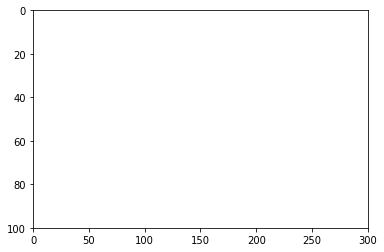

In [165]:
#plotting just the fit
plt.plot(x_range, y_range, linewidth=6)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.gca().invert_yaxis()


In [69]:
print(x_range)
print(y_range)

[  0.           6.28571429  12.57142857  18.85714286  25.14285714
  31.42857143  37.71428571  44.          50.28571429  56.57142857
  62.85714286  69.14285714  75.42857143  81.71428571  88.
  94.28571429 100.57142857 106.85714286 113.14285714 119.42857143
 125.71428571 132.         138.28571429 144.57142857 150.85714286
 157.14285714 163.42857143 169.71428571 176.         182.28571429
 188.57142857 194.85714286 201.14285714 207.42857143 213.71428571
 220.         226.28571429 232.57142857 238.85714286 245.14285714
 251.42857143 257.71428571 264.         270.28571429 276.57142857
 282.85714286 289.14285714 295.42857143 301.71428571 308.        ]
[ 5.97592152e+02  5.12761760e+02  4.38047260e+02  3.72780974e+02
  3.16295222e+02  2.67922325e+02  2.26994603e+02  1.92844378e+02
  1.64803970e+02  1.42205700e+02  1.24381889e+02  1.10664857e+02
  1.00386925e+02  9.28804144e+01  8.74776451e+01  8.35109381e+01
  8.03126142e+01  7.72149941e+01  7.35503985e+01  6.86511482e+01
  6.18495640e+01  5.24

In [136]:
# Load image
import cv2
image = undist
def nothing(x):
    pass
# Create a window
cv2.namedWindow('image')
cv2.namedWindow('pic')
# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('pic', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 5 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 12 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 19 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 25 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 28 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 31 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 33 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 34 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 38 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 45 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 47 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 52 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax =

KeyboardInterrupt: 